## Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as lng
import scipy.io as io
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

## Load dataset

In [32]:
data = io.loadmat('Data/zipdata.mat')

X = data['X']
y = data['y'].ravel()
N, P = X.shape
print(X.shape, y.shape)

(400, 256) (400,)


###  4: Load the zip data and make a classification using random forests. As a minimum you need to tune the parameters: The number of trees, the number of variables to sample, and the tree size. Make an effort of explaining what happens when you tune each of the parameters. Which one is more important? Additionally answer:

In [33]:
# Make a randomforrest classifier. Try to experiment with criterion, number of estimators, max_depth, min_samples_leaf
clf = RandomForestClassifier()

# use GridSearchCV to find the best model
# Define parameters to change and the values to try
# I suggest using a very small grid as it takes a long time to run otherwise
# Try implementing a small grid and then use the attached results for the discusion


rf_grid = GridSearchCV(clf, param_grid={'max_features': [20, 40, 60, 80, 100, 150, 200, 256],'n_estimators': [200, 400], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 50], 'min_samples_leaf': [1, 5, 10, 50]}, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search model
rf_grid.fit(X, y)

#Save the results in a dataframe to disk
df = pd.DataFrame(rf_grid.cv_results_)
df.to_csv('CrossValidationResultsRandomForest.csv')

print(rf_grid.best_estimator_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
RandomForestClassifier(criterion='entropy', max_depth=20, max_features=20,
                       n_estimators=200)


In [39]:
#If you just wanna read the saved results. 
#df = pd.read_csv('CrossValidationTAResultsRandomForest.csv')

df = pd.read_csv('CrossValidationResultsRandomForest.csv')

df = df.sort_values(by='rank_test_score')
print(tabulate(df[['param_n_estimators', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score', 'rank_test_score']], headers='keys', tablefmt='psql'))

+-----+----------------------+-------------------+-------------------+--------------------------+-------------------+------------------+-------------------+
|     |   param_n_estimators | param_criterion   |   param_max_depth |   param_min_samples_leaf |   mean_test_score |   std_test_score |   rank_test_score |
|-----+----------------------+-------------------+-------------------+--------------------------+-------------------+------------------+-------------------|
| 256 |                  200 | entropy           |                20 |                        1 |            0.8825 |       0.0331662  |                 1 |
| 257 |                  400 | entropy           |                20 |                        1 |            0.8825 |       0.0217945  |                 2 |
|   1 |                  400 | gini              |                10 |                        1 |            0.8825 |       0.0407738  |                 2 |
|  64 |                  200 | gini              |        

Text(0, 0.5, 'Mean test accuracy')

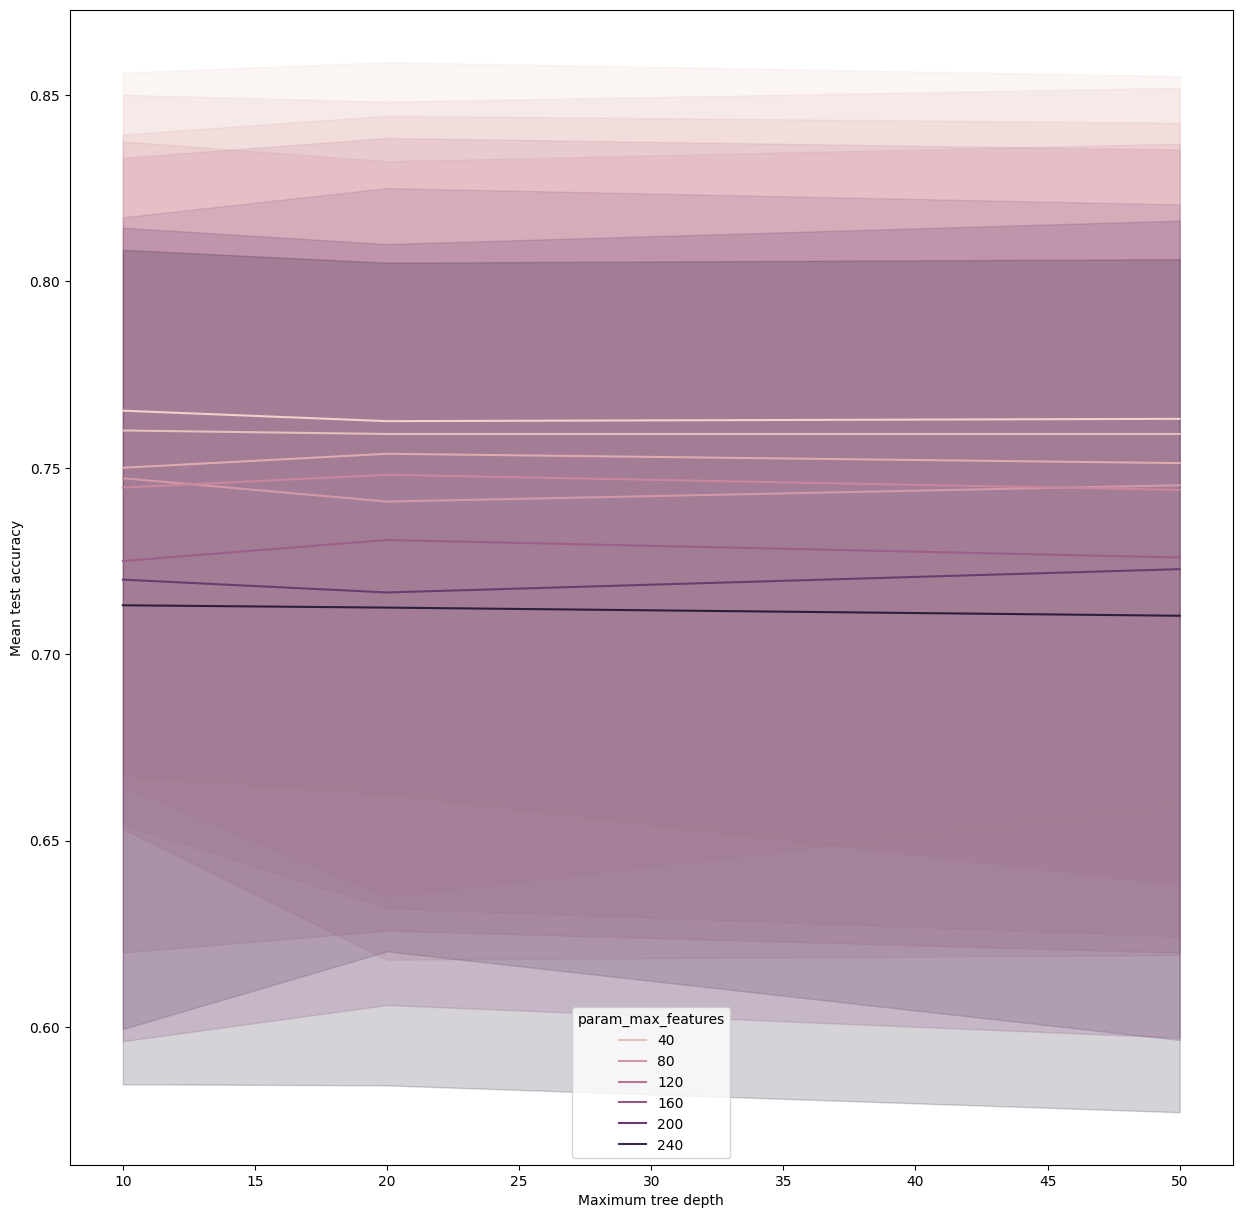

In [40]:
df_400_estimators = df[df['param_n_estimators']==400]

fig, ax = plt.subplots(figsize=(15,15))

_ = sns.lineplot(data=df_400_estimators, x='param_max_depth', y='mean_test_score', hue='param_max_features', ax=ax)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')

Text(0, 0.5, 'Mean test accuracy')

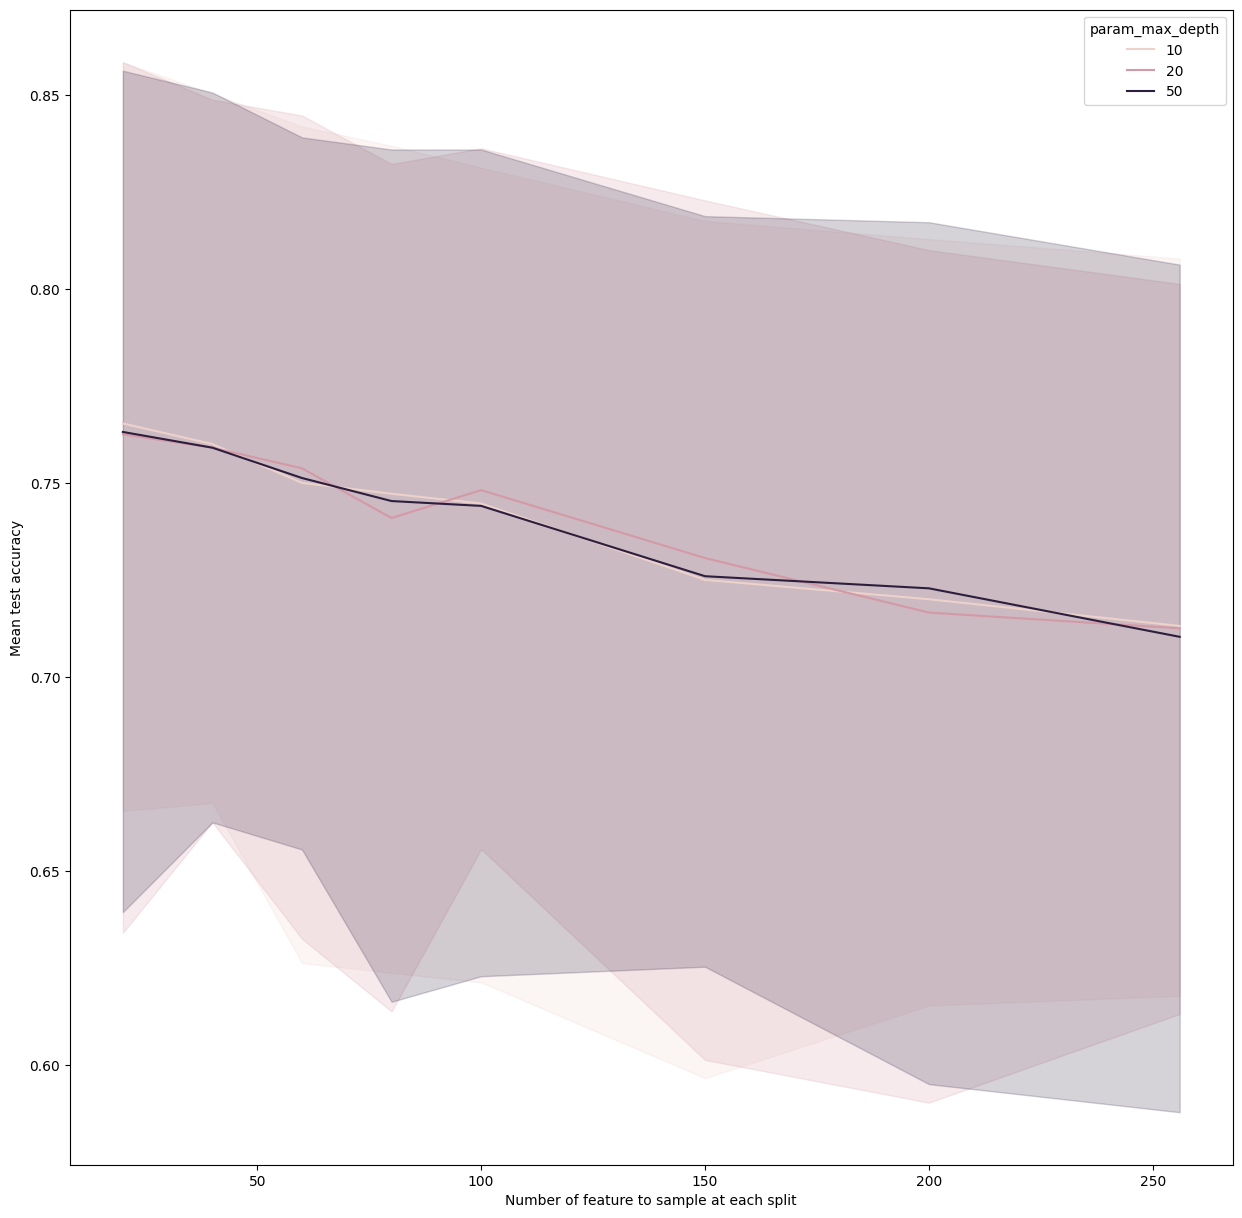

In [36]:
fig, ax = plt.subplots(figsize=(15,15))

_ = sns.lineplot(data=df_400_estimators, x='param_max_features', y='mean_test_score', hue='param_max_depth', ax=ax)
ax.set_xlabel('Number of feature to sample at each split')
ax.set_ylabel('Mean test accuracy')

Text(0, 0.5, 'Mean test accuracy')

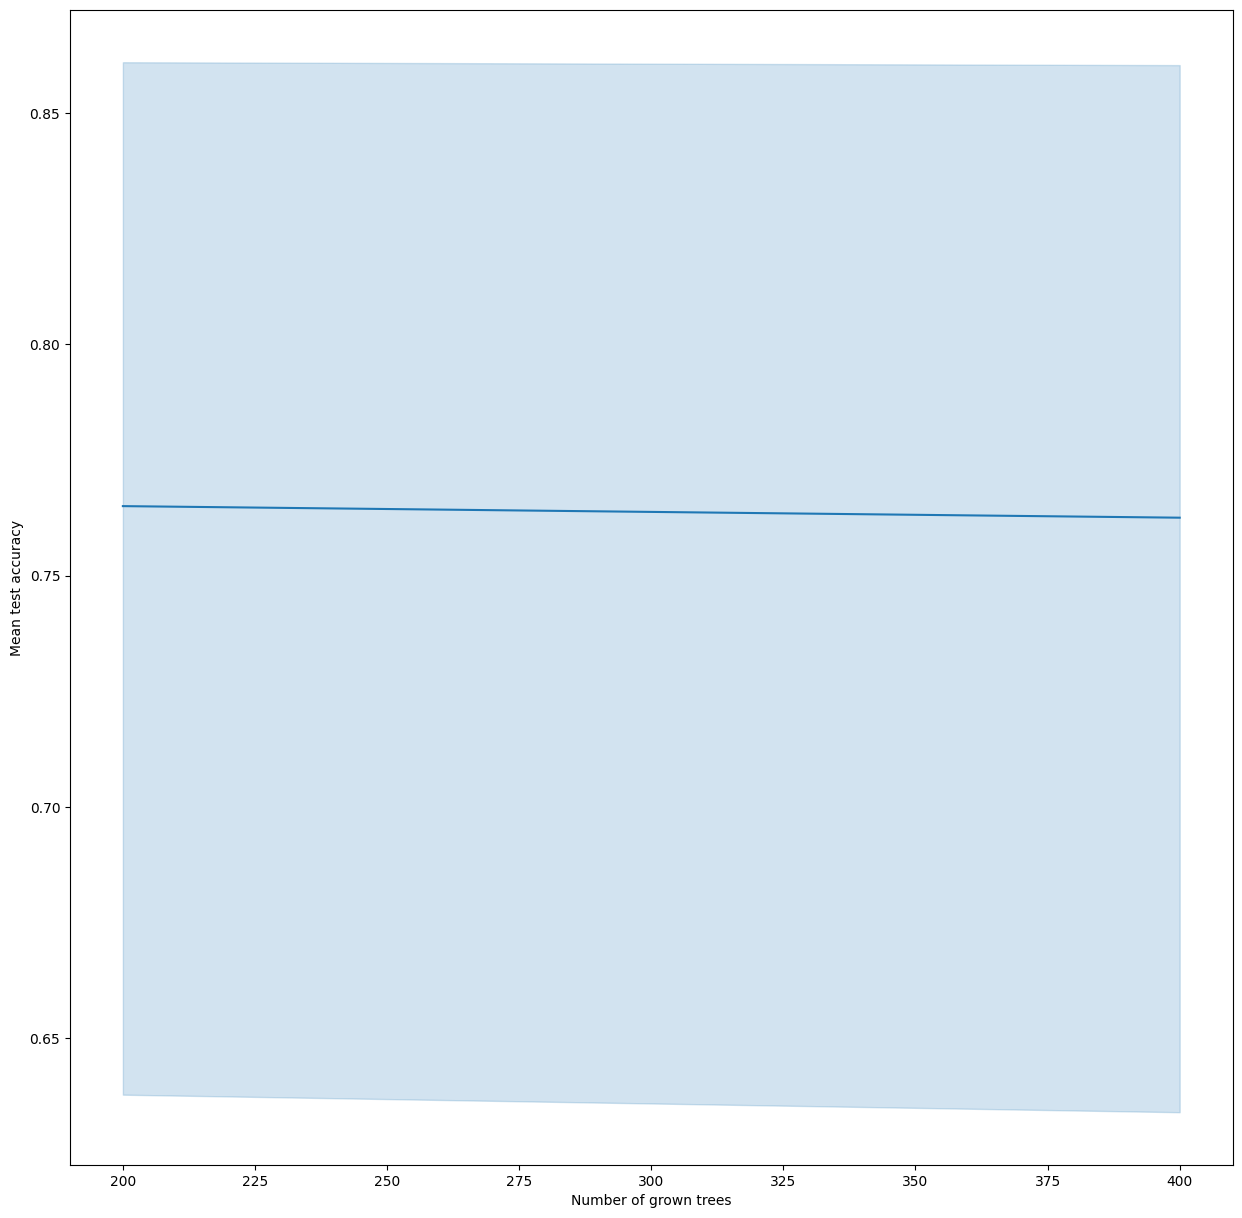

In [42]:
#We use the best to vizuallize the accuracy as a function of the grown trees
#What are they?
df_num_estimators = df[((df['param_max_features']==20) & (df['param_max_depth']==20))]

fig, ax = plt.subplots(figsize=(15,15))

_ = sns.lineplot(data=df_num_estimators, x='param_n_estimators', y='mean_test_score', ax=ax)
ax.set_xlabel('Number of grown trees')
ax.set_ylabel('Mean test accuracy')

> a) How should you set the parameters to run bagging?

To configure the Random Forest classifier to perform bagging, you need to set parameters that make it behave like a pure bagging ensemble:

1. **max_features=P (256)**: Use all available features for each tree instead of a random subset. In bagging, each base model typically has access to all features.

2. **bootstrap=True**: Ensure each tree is built using a random bootstrap sample (sampling with replacement) from the original dataset. This is the default in RandomForestClassifier.

3. **n_estimators**: Set to desired number of base models in the ensemble (e.g., 200 or 400).

Alternatively, you could directly use sklearn's `BaggingClassifier` with a decision tree as the base estimator..

> b) How should you set the parameters to run CART?

To set up a Random Forest classifier to behave like a CART (Classification and Regression Tree) model, you need to configure it as a single decision tree:

1. **n_estimators=1**: Use only one tree in the ensemble
2. **max_features=P (256)**: Consider all features at each split
3. **bootstrap=False**: Don't use bootstrap sampling (use the entire dataset)

Alternatively, you could directly use the `DecisionTreeClassifier` which is a pure implementation of CART:


> c) Plot variable importances and a variable correlation matrix. How do you interpret
these?

In [45]:
## Look at the best estimator and the importance of the features
# Get the best parameters from GridSearchCV
best_params = rf_grid.best_params_.copy()
# Add oob_score=True to enable out-of-bag estimation
best_params['oob_score'] = True

# Create and fit a new RandomForestClassifier with the best parameters and OOB scoring enabled
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X, y)

# Get feature importances
headers = ["name", "score"]
values = sorted(zip(range(0,P), rf_grid.best_estimator_.feature_importances_), key=lambda x: x[1] * -1)

# See which features are deemed most important by the classifier
# Only gonna look at the 10 most important features out of 256
print(tabulate(values[0:10], headers[0:2], tablefmt="plain"))
print('Random Forest OOB error rate: {}'.format(1 - best_rf.oob_score_))

  name      score
   196  0.0231823
   212  0.0210973
   195  0.0182879
   151  0.018218
   120  0.0175945
   104  0.0175654
    37  0.0175158
   119  0.0170816
    75  0.0156129
   229  0.0151742
Random Forest OOB error rate: 0.09750000000000003


> d) Add five randomly generated, white noise, variables to the dataset and investigate
how you can use their information to derive a cut-off value to select varaibles based
on the variable importances

In [46]:

np.random.seed(0)  
white_noise = np.random.rand(X.shape[0], 5) 
X_with_white_noise_features = np.hstack((X, white_noise))  

# Here we refit the model to the data including the white noise attributes
score = rf_grid.best_estimator_.fit(X_with_white_noise_features, y)
feature_importances = rf_grid.best_estimator_.feature_importances_
headers = ["name", "score"]
#Add labels for the white noise features as well
feature_names = [f"Feature {i}" for i in range(P)] + [f"White Noise {i}" for i in range(1, 6)]
values = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances, for cut off look at the sorted list of variables
print(tabulate(values, headers=headers, tablefmt="plain"))


name                 score
Feature 196    0.0223387
Feature 75     0.0198402
Feature 37     0.0192949
Feature 212    0.0191756
Feature 151    0.0187756
Feature 104    0.0179359
Feature 119    0.0171889
Feature 211    0.0147178
Feature 195    0.0142139
Feature 229    0.0140956
Feature 120    0.0137543
Feature 213    0.0134777
Feature 152    0.0130736
Feature 203    0.0127744
Feature 219    0.0125481
Feature 136    0.0125232
Feature 135    0.0116761
Feature 103    0.0111419
Feature 168    0.0102789
Feature 91     0.00999845
Feature 105    0.00965607
Feature 204    0.00937402
Feature 71     0.00937254
Feature 74     0.0092438
Feature 218    0.00923018
Feature 118    0.0091054
Feature 115    0.00903199
Feature 26     0.00856984
Feature 184    0.00829103
Feature 58     0.008076
Feature 179    0.00802373
Feature 248    0.00800057
Feature 21     0.00786052
Feature 138    0.0078216
Feature 131    0.00779724
Feature 180    0.00776911
Feature 22     0.0075852
Feature 90     0.00757782
Feature 18